In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
import pyccl as ccl
from pyccl import halos
from gadgetutils import snapshot, utils

In [2]:
plt.style.use(["science", "notebook"])

## Set up theory predictions
Planck 2018 cosmology: $\Omega_m = 0.315$, $\Omega_b = 0.049$, $h = 0.674$, $n_s = 0.965$, $\sigma_8 = 0.811$

Initialize `cosmo` object with $h = 1$ to factor out $h$ from results

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.315, Omega_b=0.049, h=1, sigma8=0.811, n_s=0.965)

# Tests
Test results of run 4

## Time output density slices

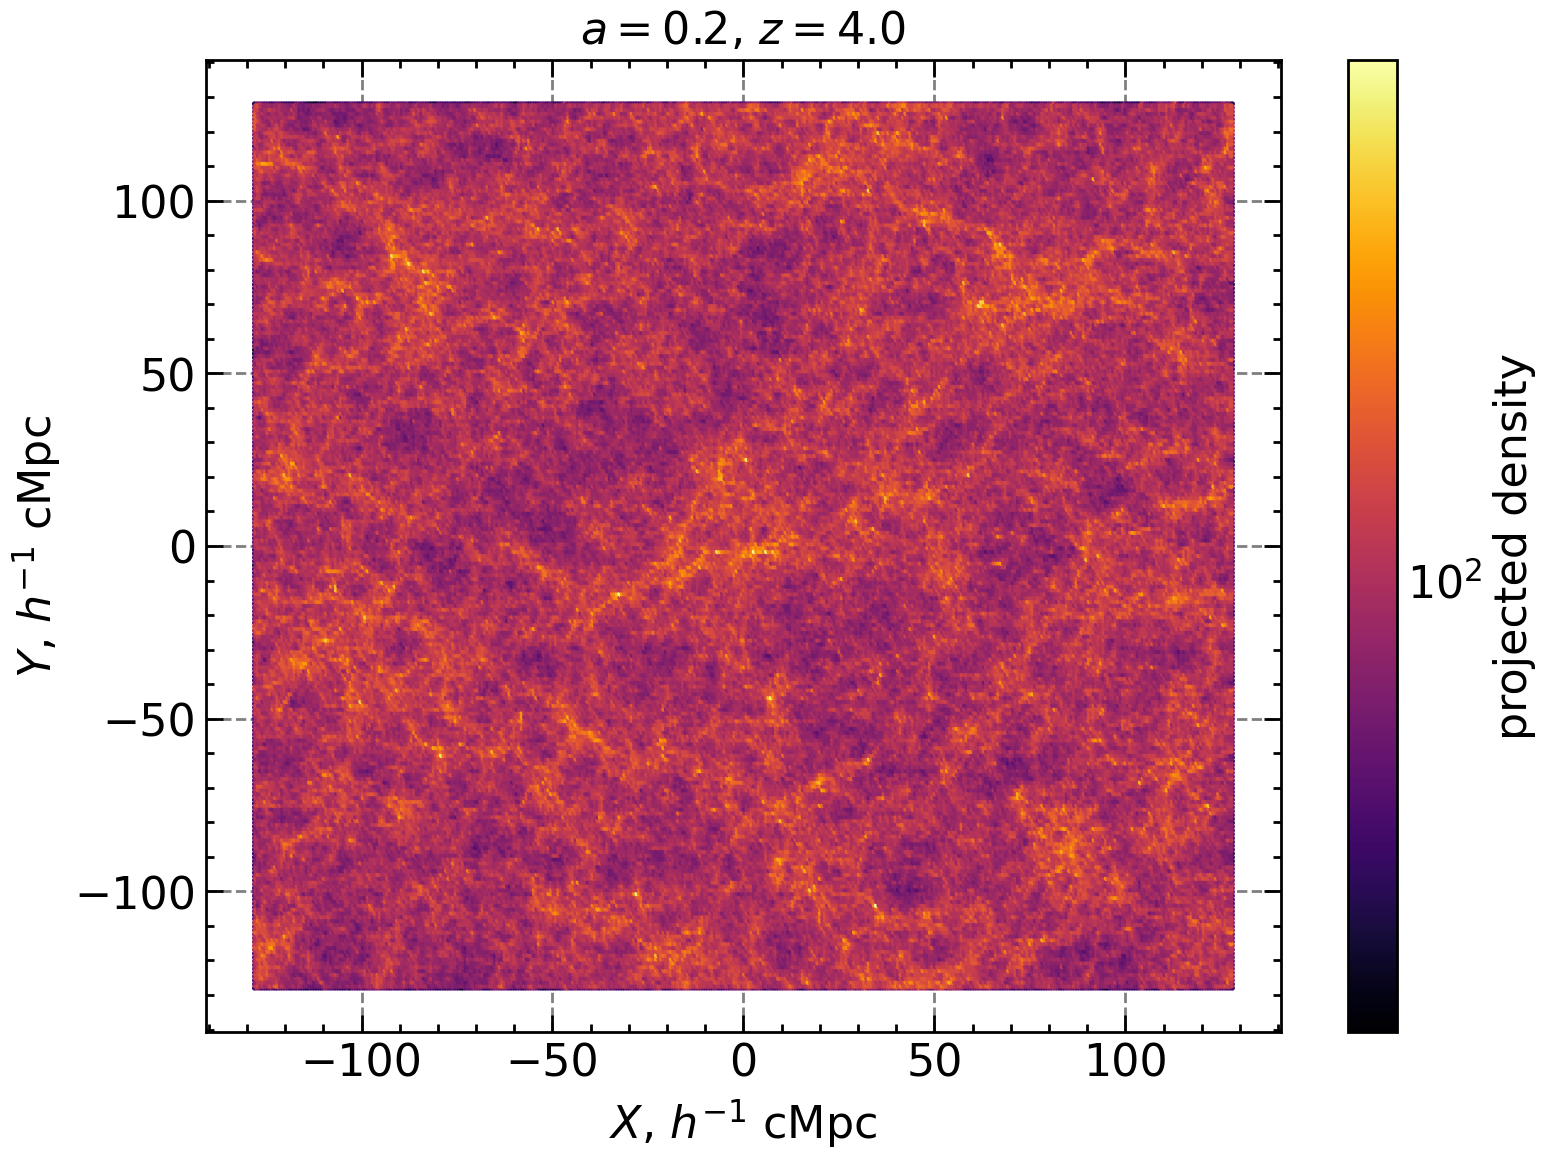

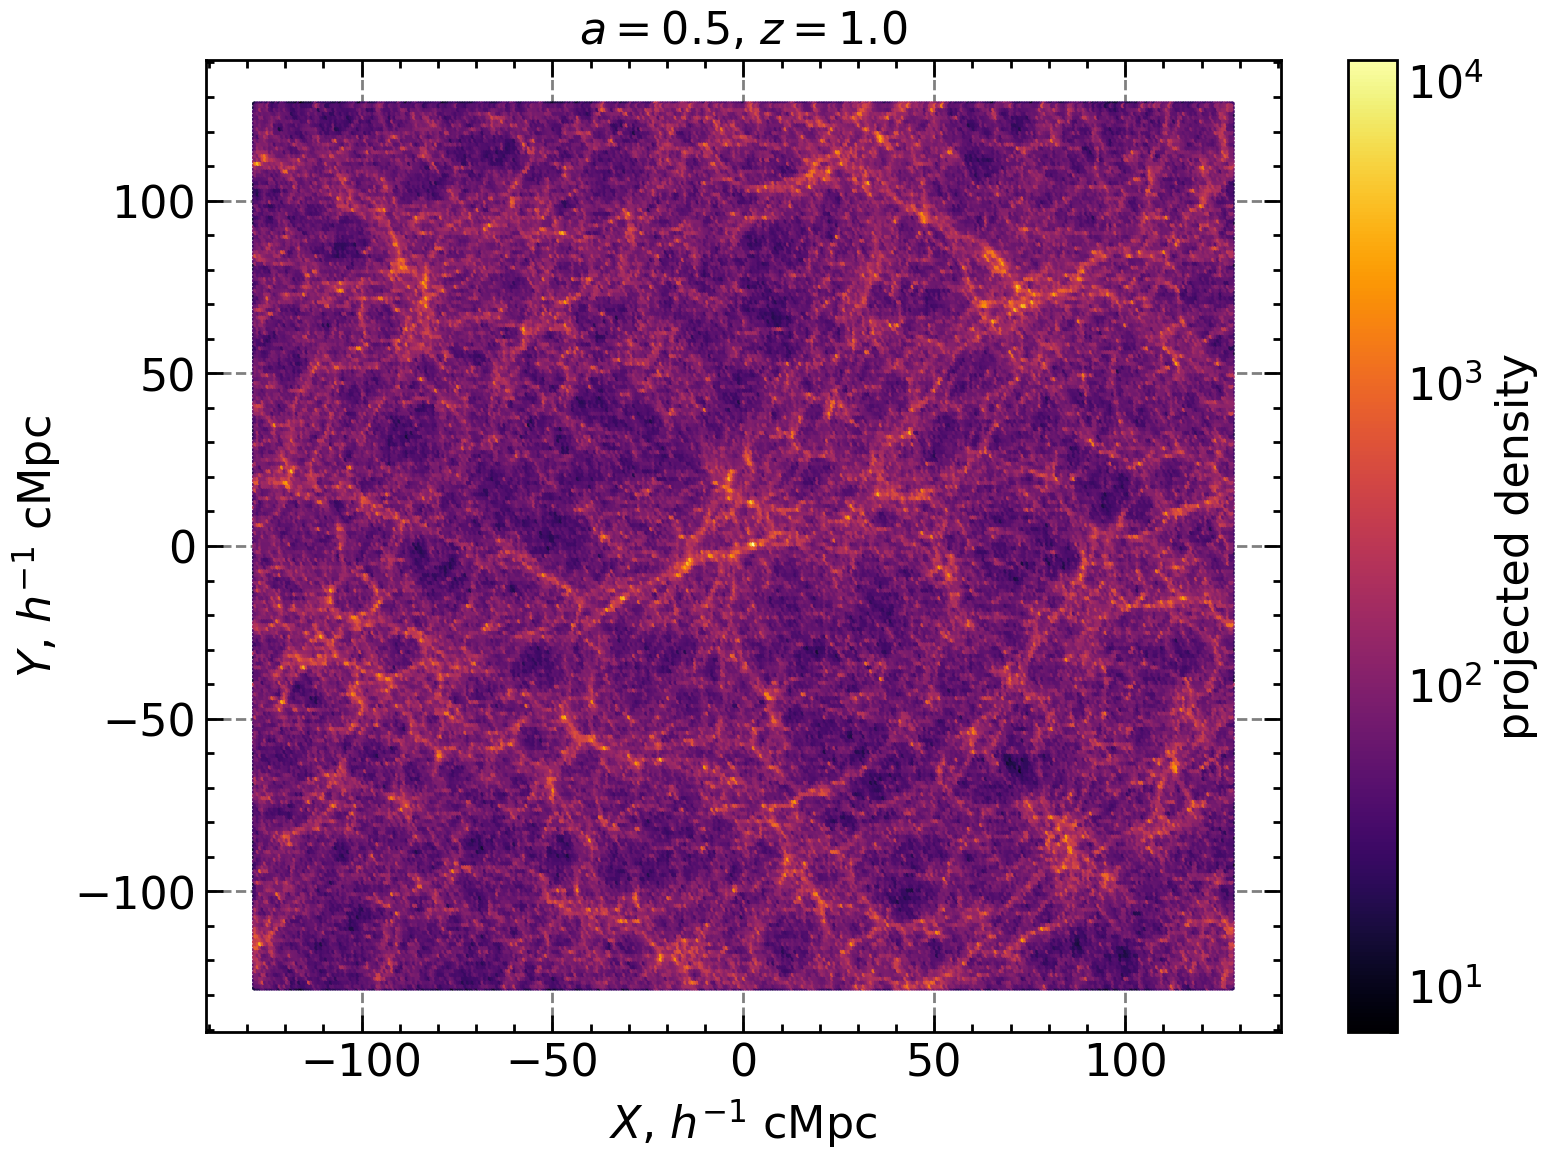

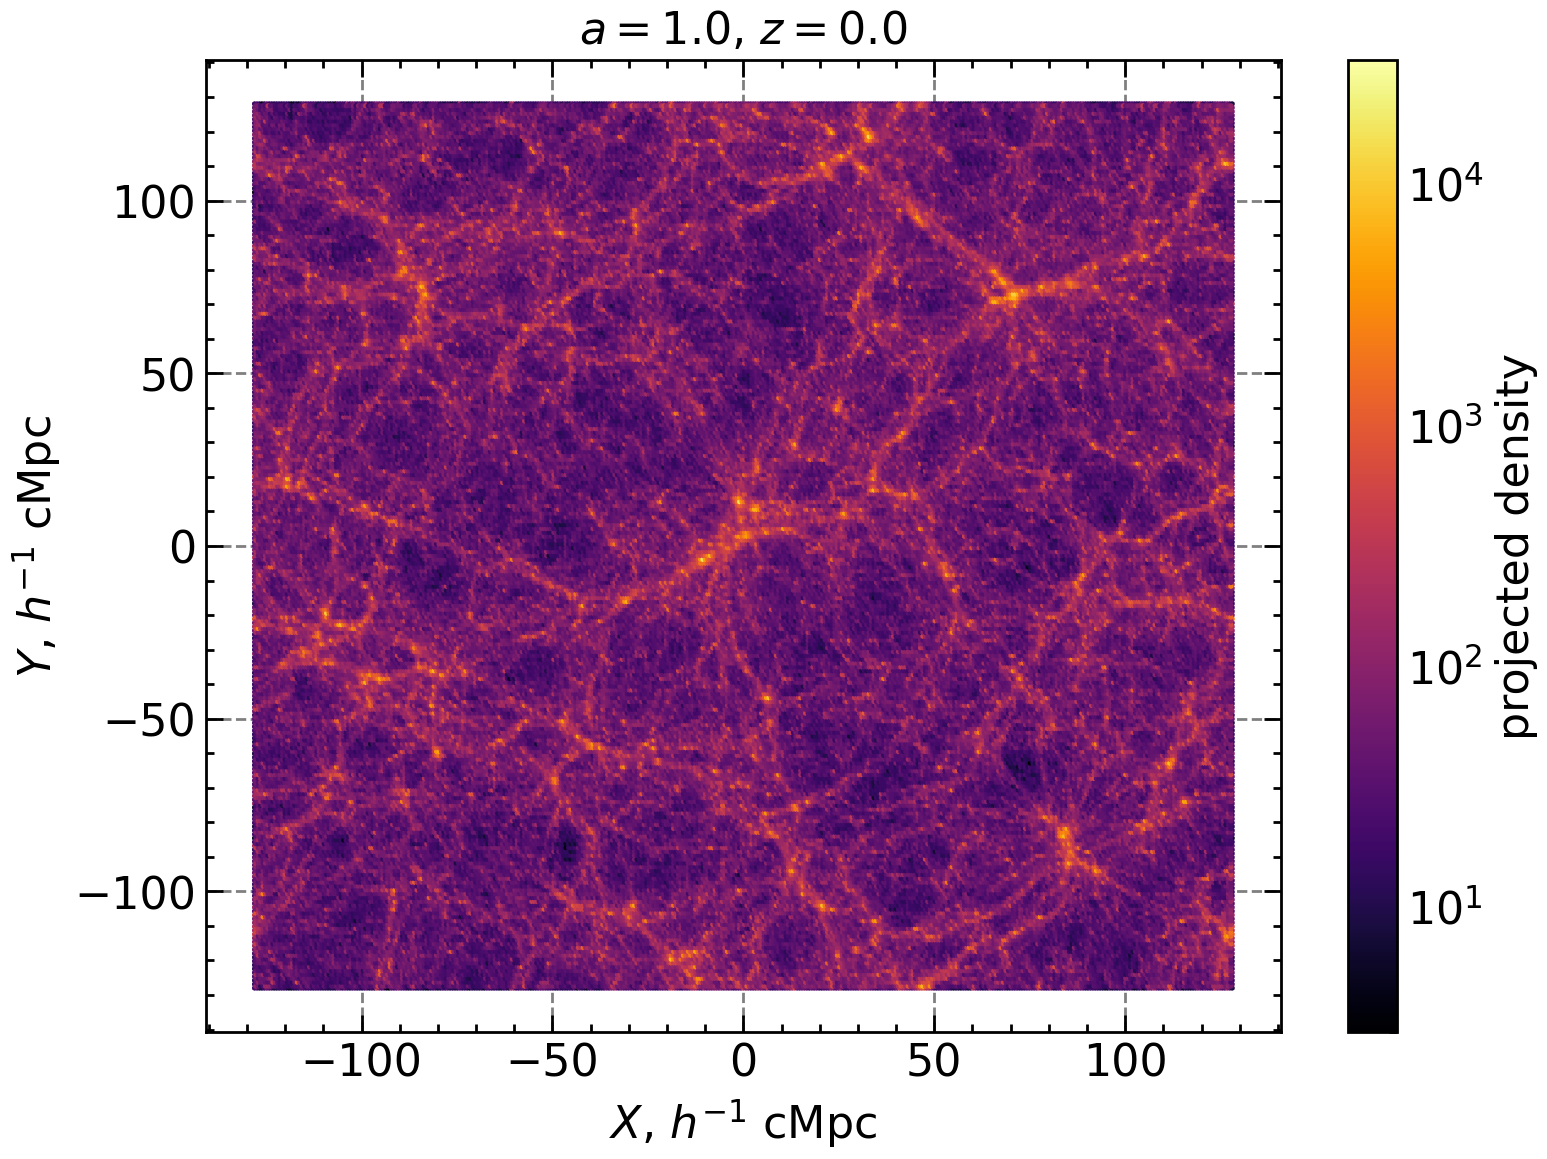

In [17]:
center = np.array([0, 0, 0])

for i, snap in enumerate([1, 4, 9]):
    pd = snapshot.load(f"/home/aaronjo2/caps/dm-l256-n512-a100-rerun/snapshot_{snap:03}.hdf5", load_vels=False, load_ids=False)
    pos = utils.center_box_pbc(pd.pos, center, pd.box_size)
    mask = np.nonzero(np.abs(pos[:,2]) < 20)
    
    plt.figure(dpi=200, frameon=False, tight_layout=True)
    plt.hexbin(pos[mask,0], pos[mask,1], norm=LogNorm(), gridsize=400, cmap="inferno")
    plt.colorbar(label="projected density")
    plt.title(f"$a = {pd.a:.1f}$, $z = {abs(pd.z):.1f}$")
    plt.xlabel("$X$, $h^{-1}$ cMpc")
    plt.ylabel("$Y$, $h^{-1}$ cMpc")
    plt.show()

## Power spectrum

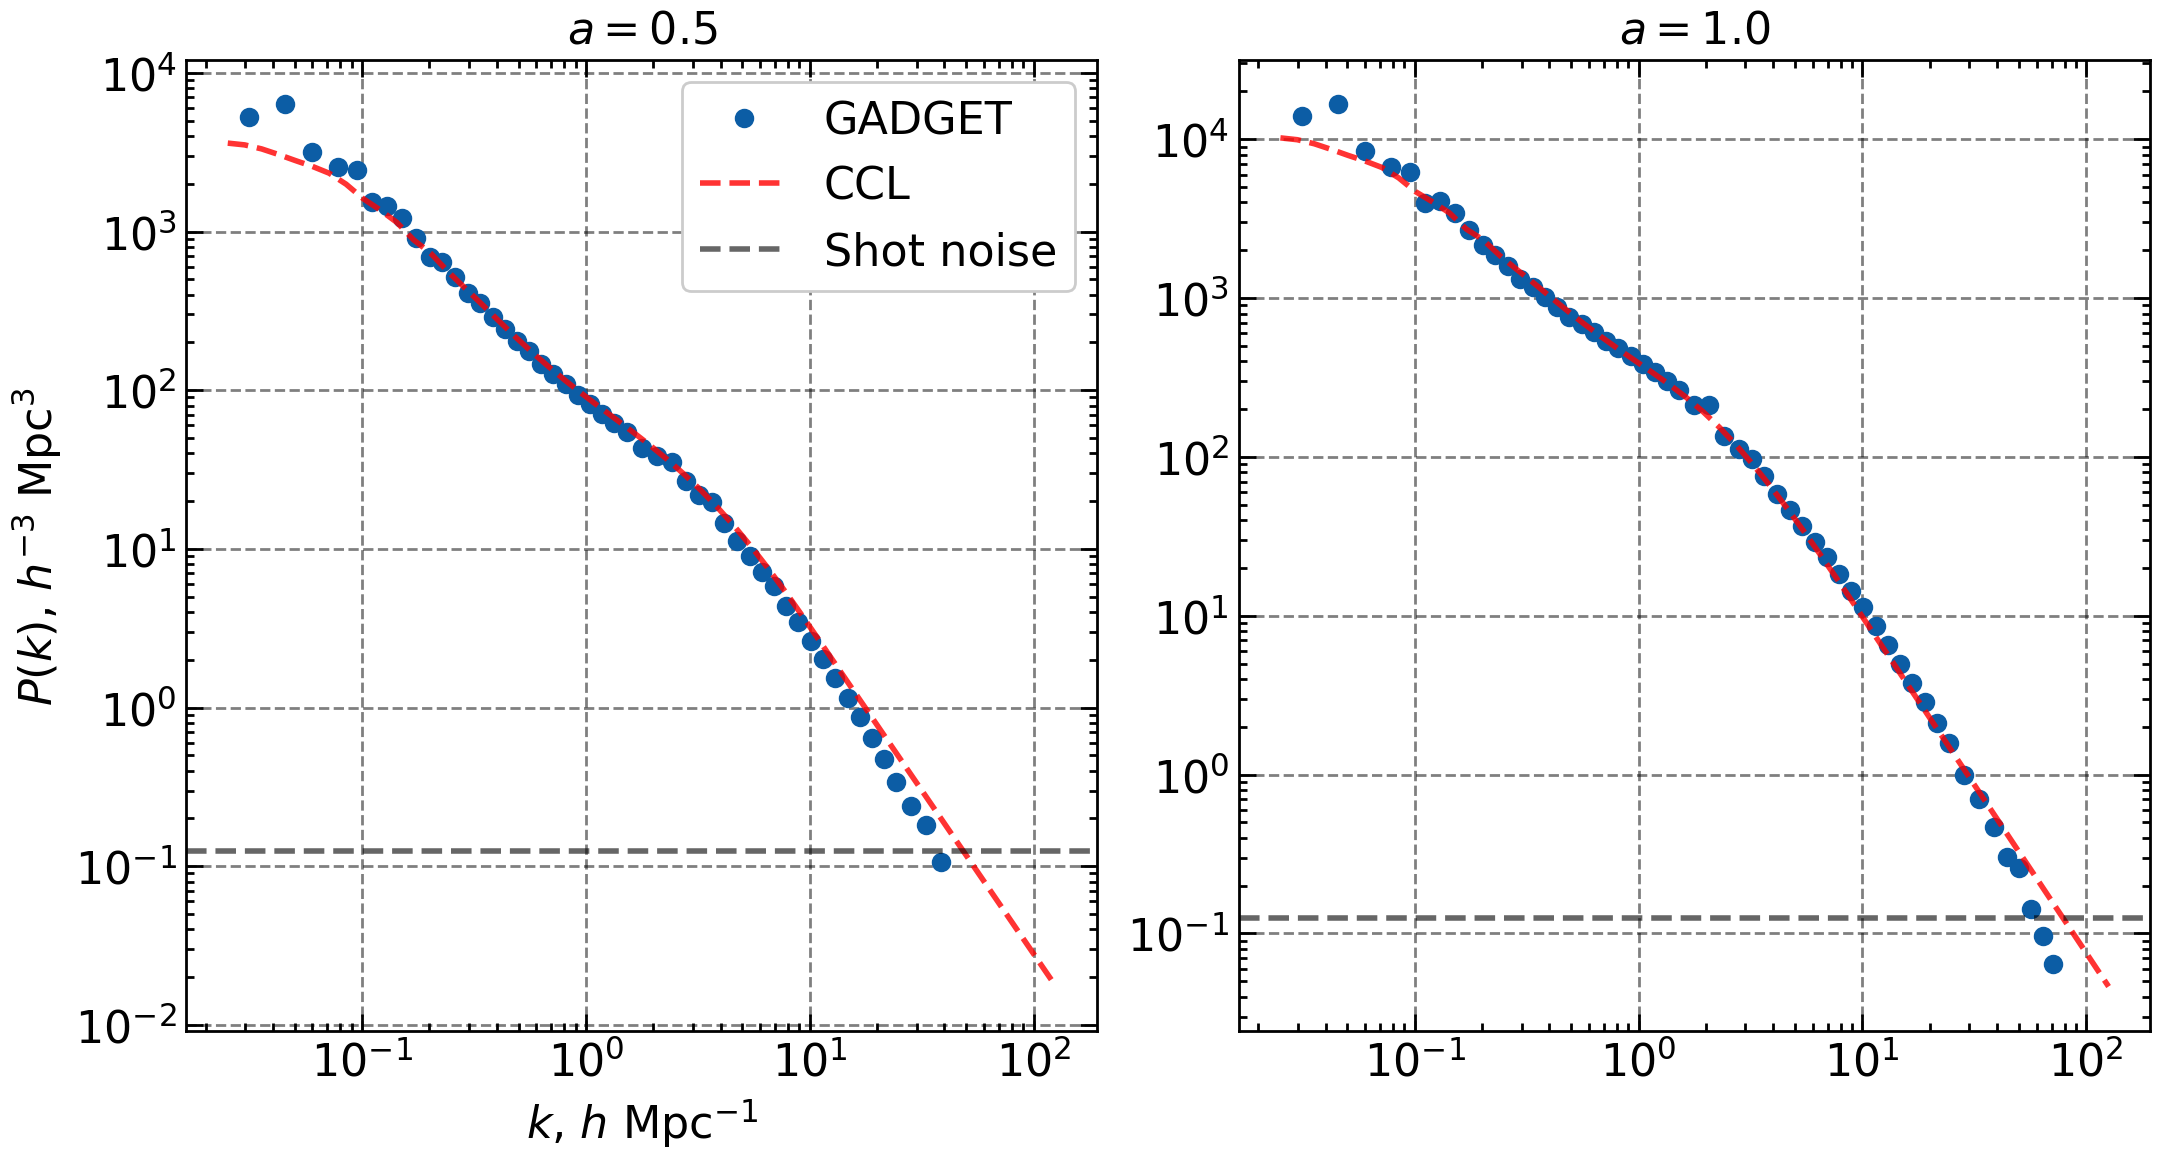

In [85]:
k_ccl = np.logspace(-1.6, 2.1, 50)
ps_ccl = [cosmo.nonlin_power(k_ccl, 0.5), cosmo.nonlin_power(k_ccl, 1)]
a = [0.5, 1]
k_nyq = 2*np.pi / 256 * 512 / 2

plt.figure(figsize=(11,6), tight_layout=True, dpi=200)
for i in range(1,3):
    data = np.load(f"summary_data/run4/powerspec_{i:03}.npz")
    k = data["k"]
    delta = data["delta"]
    ps = 2*np.pi**2 * delta / k**3

    plt.subplot(1,2,i)
    plt.plot(k, ps, 'o', label="GADGET")
    plt.plot(k_ccl, ps_ccl[i-1], 'r--', alpha=0.8, label="CCL")
    plt.axhline(1/8, ls='--', alpha=0.6, color='black', label="Shot noise")
    #plt.axvline(k_nyq, ymax=0.75, ls='dashdot', alpha=0.6, color='black')
    plt.loglog()
    plt.title(f"$a = {a[i-1]:.1f}$")
    if i == 1:
        plt.legend(frameon=True)
        plt.xlabel("$k$, $h$ Mpc$^{-1}$")
        plt.ylabel("$P(k)$, $h^{-3}$ Mpc$^3$")
        
plt.show()

## HMF

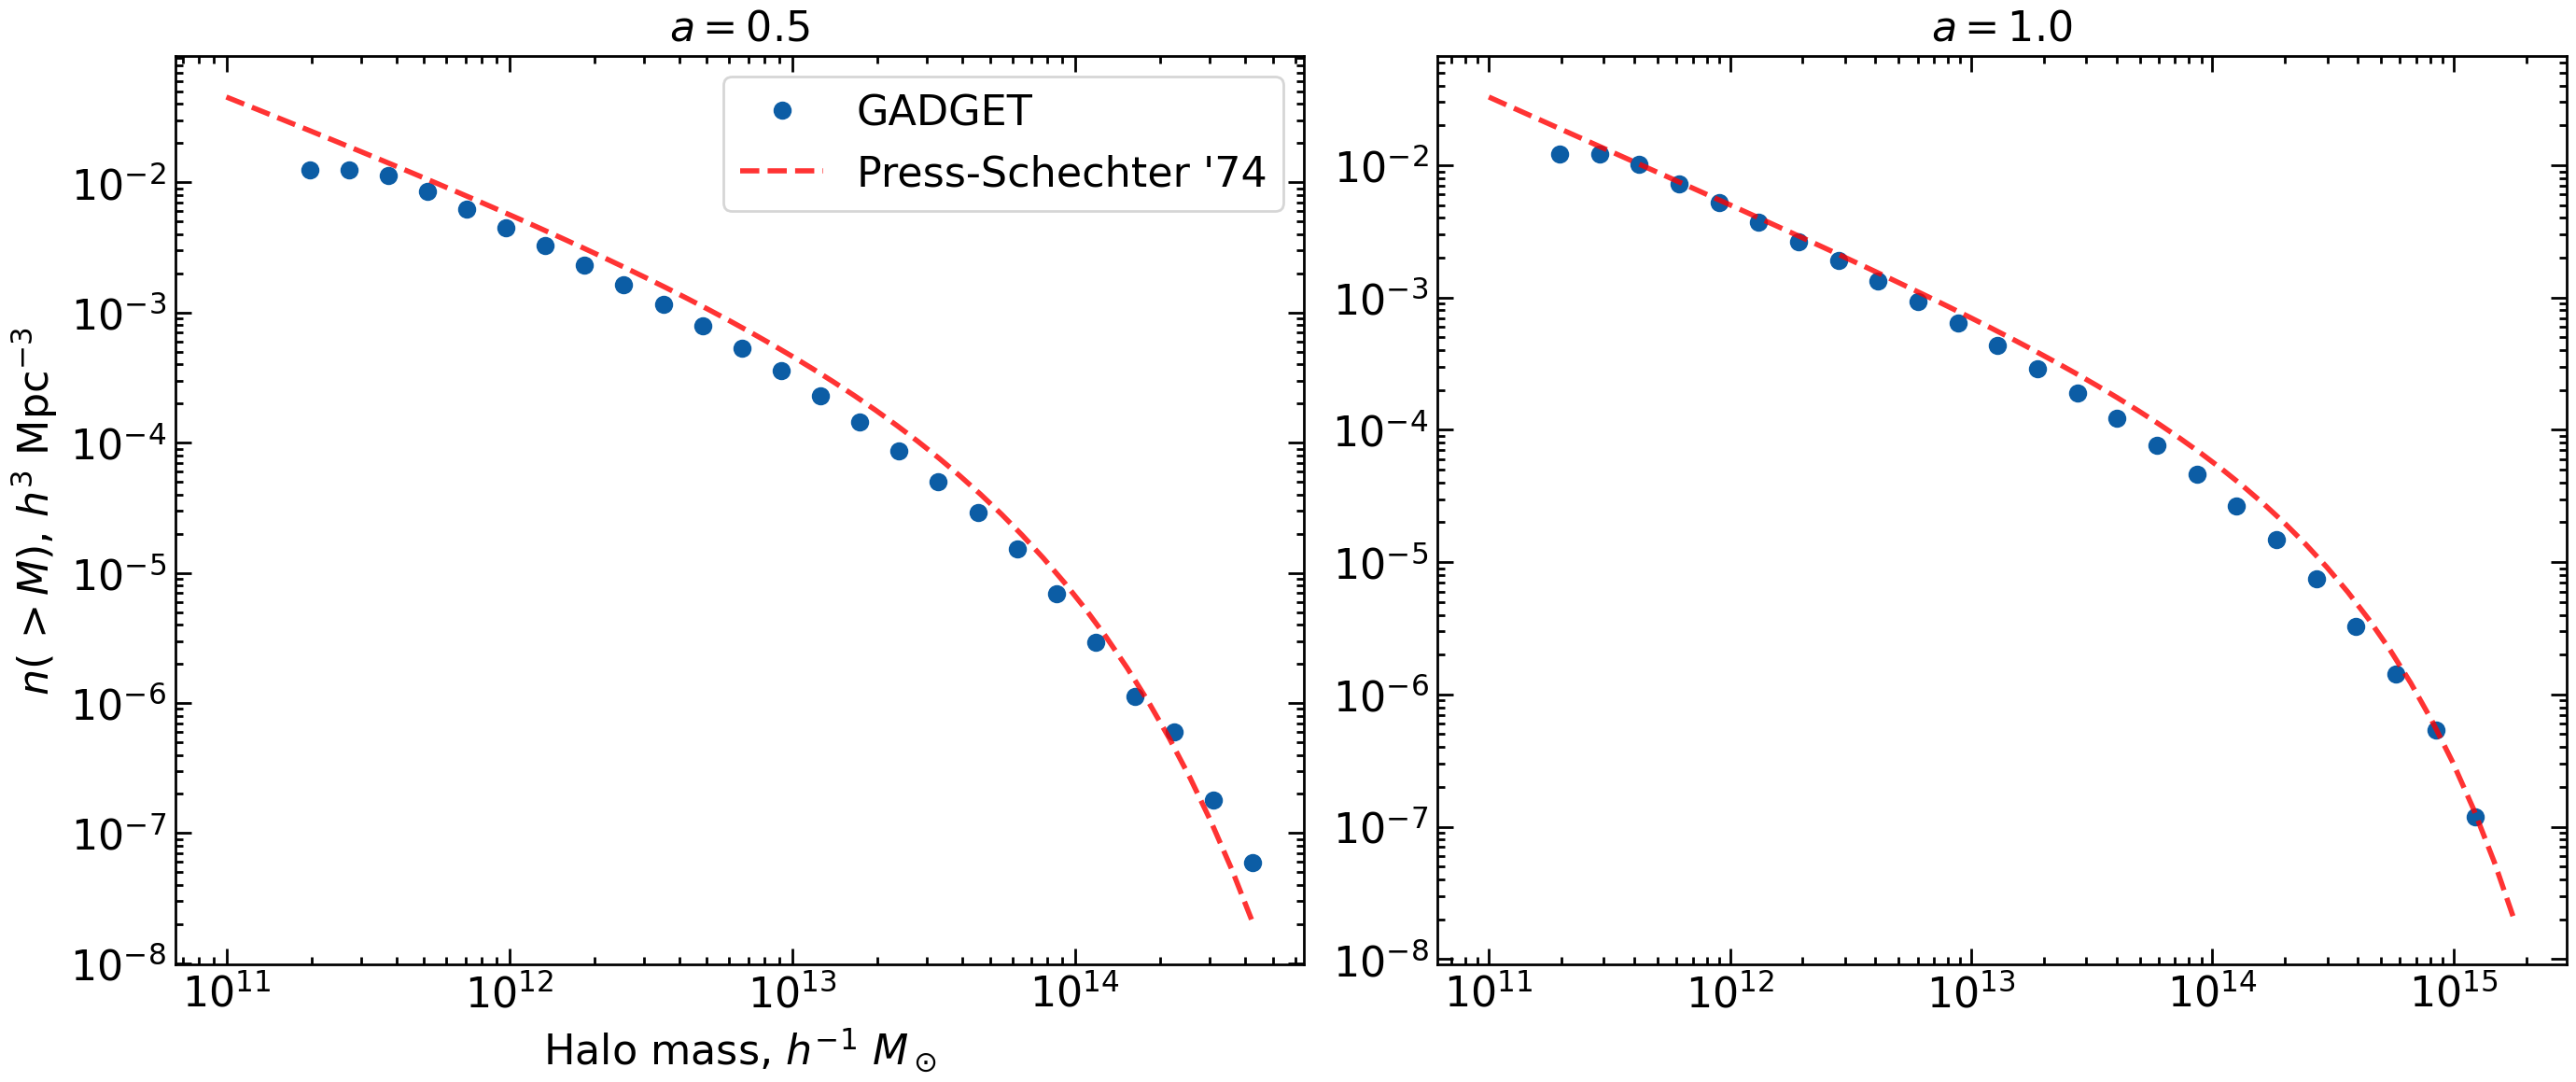

In [10]:
plt.figure(figsize=(14,6), tight_layout=True, dpi=200)
for i in range(1, 3):
    hc = snapshot.load(f"/home/aaronjo2/caps/astr510_sims/run4/fof_subhalo_tab_{i:03}.hdf5")
    mass_bins = np.logspace(np.log10(np.min(hc.masses))-0.25, np.log10(np.max(hc.masses)), 25)

    hmf_press = halos.hmfunc.MassFuncPress74(cosmo)
    mass_ccl = np.logspace(11, np.log10(np.max(hc.masses)), 50)
    hmf_ps = hmf_press.get_mass_function(cosmo, mass_ccl, min(hc.a, 1)) * hc.h**3

    plt.subplot(1,2,i)
    plt.plot(mass_bins, hc.calc_fof_hmf(mass_bins)[0], 'o', label="GADGET")
    plt.plot(mass_ccl, hmf_ps, 'r--', alpha=0.8, label="Press-Schechter '74")
    plt.title(f"$a = {hc.a:.1f}$")
    plt.loglog()
    if i == 1:
        plt.legend(frameon=True)
        plt.xlabel("Halo mass, $h^{-1}$ $M_\odot$")
        plt.ylabel("$n(\,>M)$, $h^3$ Mpc$^{-3}$")
    
plt.show()

[]

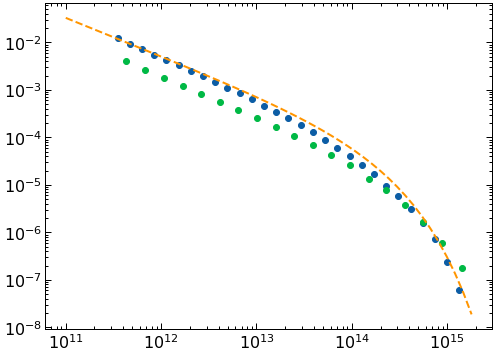

In [47]:
from scipy.integrate import quad


hmf, errors = hc.calc_fof_hmf(mass_bins)

bins = np.logspace(np.log10(np.min(hc.masses)), np.log10(np.max(hc.masses)), 20)
bin_inds = np.digitize(hc.masses, bins)
hmf2 = np.bincount(bin_inds)[1:] / hc.box_size**3
bin_avgs = np.zeros_like(hmf2)
for i in range(1, 1+len(hmf2)):
    bin_avgs[i-1] = np.mean(hc.masses[bin_inds == i])

    
plt.plot(mass_bins, hmf, 'o')
plt.plot(bin_avgs, hmf2, 'o')
plt.plot(mass_ccl, hmf_ps, '--')
#plt.plot(mass_ccl[1:-1], -hmf_ps[2:] + hmf_ps[:-2])
plt.loglog()

## Density profiles

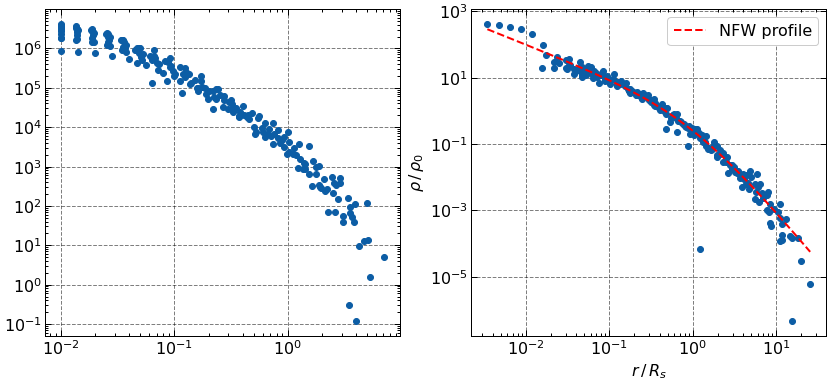

In [76]:
data = np.load("summary_data/run4/density_profiles_002.npz")

r = np.logspace(np.log10(np.min(data["r_scaled"])), np.log10(np.max(data["r_scaled"])), 50)
nfw_profile = 1/(r * (1+r)**2)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(data["r"], data["density"], 'o')
plt.loglog()

plt.subplot(1,2,2)
plt.plot(data["r_scaled"], data["density_scaled"], 'o')
plt.plot(r, nfw_profile, 'r--', label="NFW profile")
plt.loglog()
plt.xlabel("$r\,/\,R_s$")
plt.ylabel("$\\rho\,/\,\\rho_0$")
plt.legend(frameon=True)
#plt.ylim(top=1e3)
plt.show()

# Number of particles
Runs 1-4: keep $L$ constant, increase $N$ from $64^3$ to $512^3$

## Slices

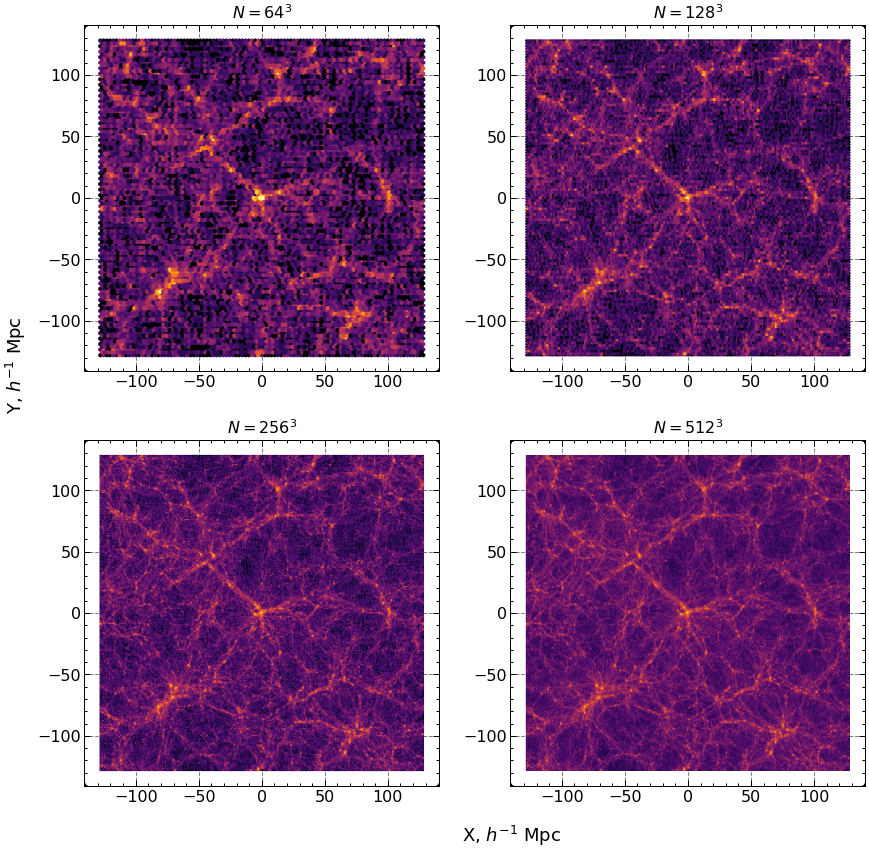

In [91]:
center = np.array([71, 72, 242])
gridsizes = [100, 200, 400, 800]

plt.figure(figsize=(14,14))
for i in range(1, 5):
    plt.subplot(2,2,i)
    pd = snapshot.load(f"/home/aaronjo2/caps/astr510_sims/run{i}/snapshot_002.hdf5", load_vels=False)
    pos = utils.center_box_pbc(pd.pos, center, pd.box_size)
    zslice = np.nonzero(np.abs(pos[:,2]) < 20)
    plt.hexbin(pos[zslice,0], pos[zslice,1], norm=LogNorm(), cmap="inferno", gridsize=gridsizes[i-1])
    plt.title(f"$N = {round(pd.n_parts**(1/3))}^3$")

plt.figtext(0.045, 0.5, "Y, $h^{-1}$ Mpc", rotation="vertical", fontsize=18)
plt.figtext(0.5, 0.07, "X, $h^{-1}$ Mpc", fontsize=18)
plt.show()

## Power spectra

In [40]:
k_ccl = np.logspace(-1.6, 2, 100)
ps_ccl = cosmo.nonlin_power(k_ccl, 1)
delta_ccl = k_ccl**3 / (2*np.pi**2) * ps_ccl

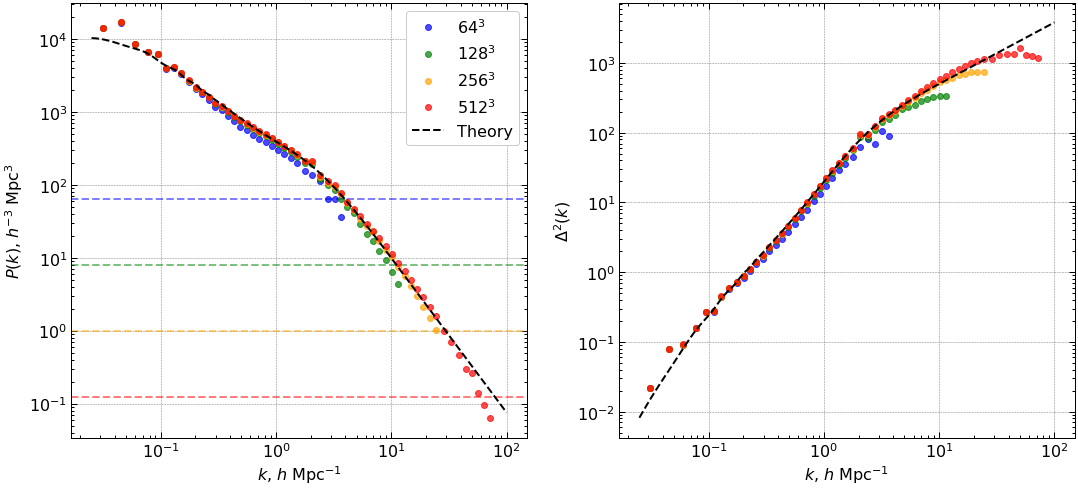

In [43]:
shot_noise = [64, 8, 1, 1/8]
labels = ["$64^3$", "$128^3$", "$256^3$", "$512^3$"]
colors = ["blue", "green", "orange", "red"]
plt.figure(figsize=(18,8))

for i in range(1,5):
    data = np.load(f"summary_data/run{i}/powerspec_002.npz")
    k = data["k"]
    delta = data["delta"]
    ps = 2*np.pi**2 * delta / k**3
    plt.subplot(1,2,1)
    plt.plot(k, ps, 'o', alpha=0.7, label=labels[i-1], color=colors[i-1])
    plt.axhline(shot_noise[i-1], ls='--', alpha=0.5, color=colors[i-1])
    plt.subplot(1,2,2)
    plt.plot(k, delta, 'o', alpha=0.7, label=labels[i-1], color=colors[i-1])

plt.subplot(1,2,1)
plt.plot(k_ccl, ps_ccl, 'k--', label="Theory")
plt.xlabel("$k$, $h$ Mpc$^{-1}$")
plt.ylabel("$P(k)$, $h^{-3}$ Mpc$^3$")
plt.loglog()
plt.legend()

plt.subplot(1,2,2)
plt.plot(k_ccl, delta_ccl, 'k--')
plt.loglog()
plt.xlabel("$k$, $h$ Mpc$^{-1}$")
plt.ylabel("$\\Delta^2(k)$")
plt.show()

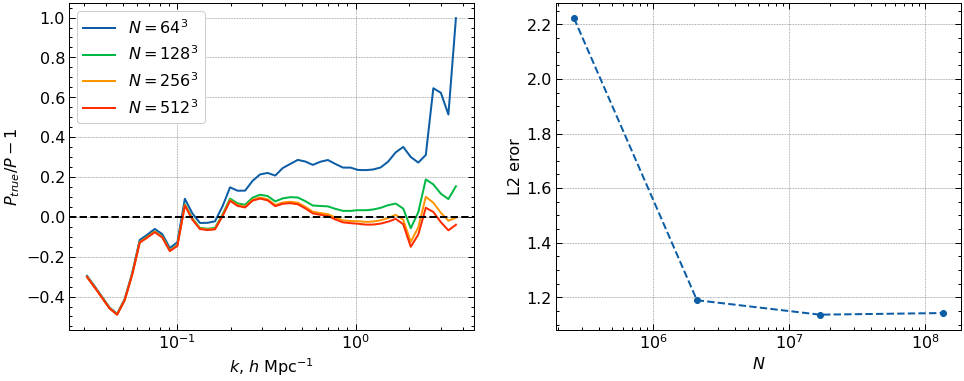

In [48]:
data = np.load("summary_data/run1/powerspec_002.npz")
kmax = np.max(data["k"])
kmin = np.min(data["k"])

k_ccl = np.logspace(np.log10(kmin), np.log10(kmax), 50)
ps_ccl = cosmo.nonlin_power(k_ccl, 1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
errors = []
for i in range(1,5):
    data = np.load(f"summary_data/run{i}/powerspec_002.npz")
    k = data["k"]
    mask = k <= kmax
    delta = data["delta"]
    ps = 2*np.pi**2 * delta / k**3
    ps_interp = interp1d(k[mask], ps[mask])(k_ccl)
    transfer_func = ps_ccl / ps_interp
    error = np.linalg.norm(transfer_func - 1)
    errors.append(error)
    plt.plot(k_ccl, transfer_func - 1, label="$N = $"+labels[i-1])

plt.xscale('log')
plt.axhline(0, ls='--', color='black')
plt.xlabel("$k$, $h$ Mpc$^{-1}$")
plt.ylabel("$P_{true} / P - 1$")
plt.legend()

plt.subplot(1,2,2)
plt.plot([64**3, 128**3, 256**3, 512**3], errors, 'o--')
plt.xscale('log')
plt.xlabel("$N$")
plt.ylabel("L2 eror")
plt.show()

## Correlation functions

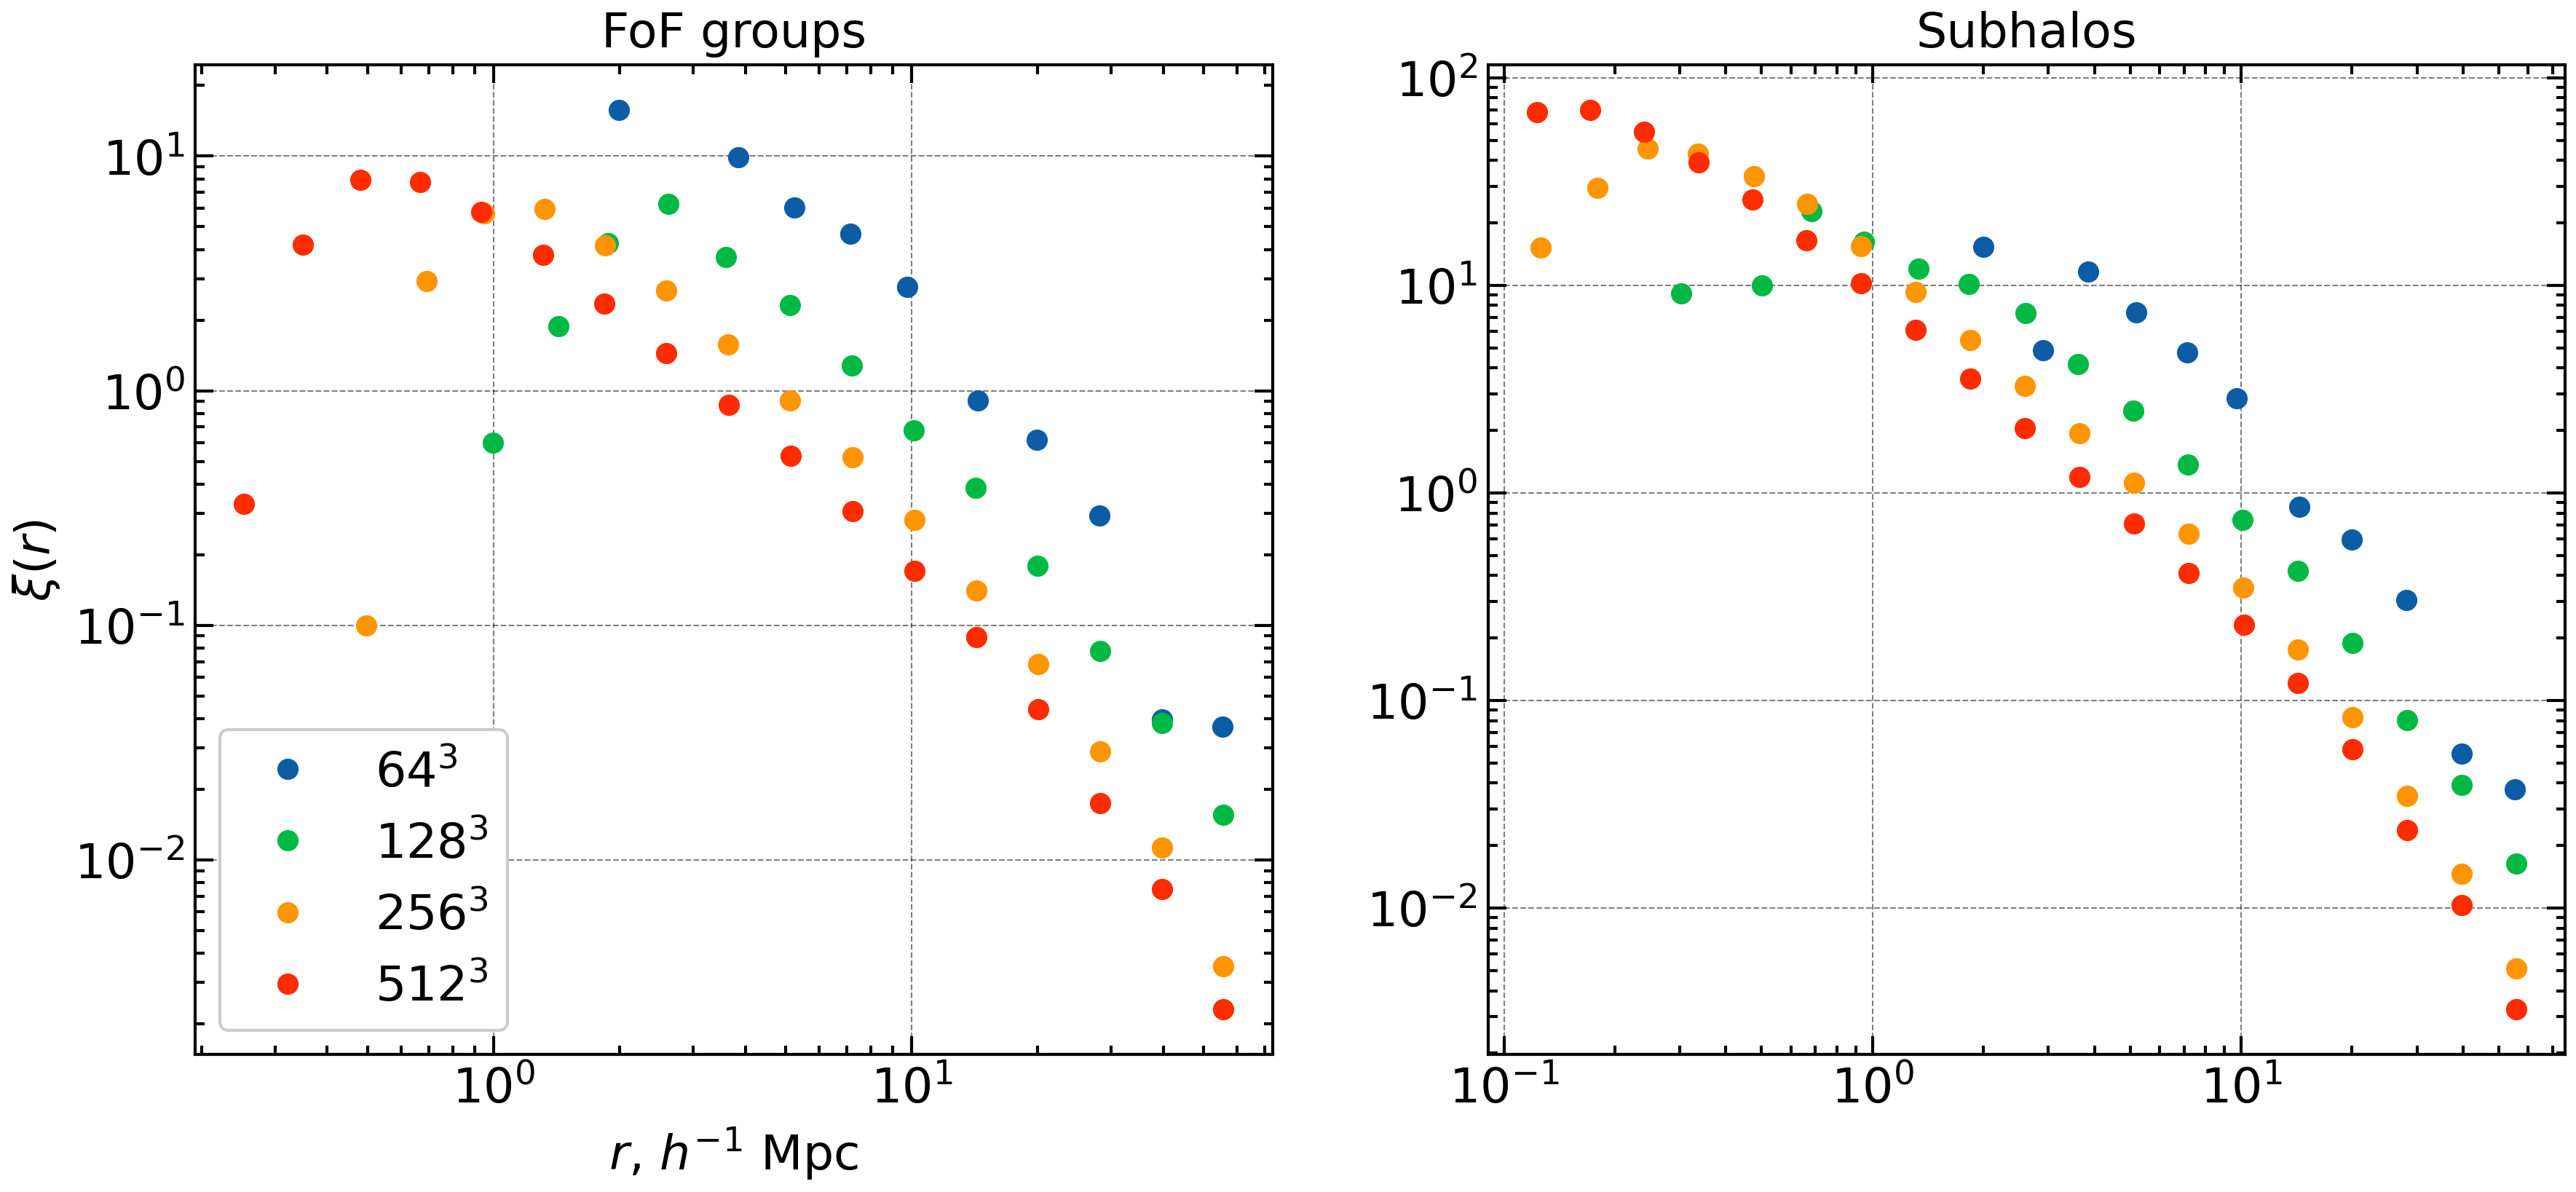

In [45]:
plt.figure(figsize=(14,6), dpi=300)
for i in range(1, 5):
    data = np.load(f"summary_data/run{i}/correlations_002.npz")
    corr_fof = data["results_fof"]
    corr_sh = data["results_sh"]
    plt.subplot(1,2,1)
    plt.plot(corr_fof["ravg"], corr_fof["xi"], 'o', label=labels[i-1])
    plt.subplot(1,2,2)
    plt.plot(corr_sh["ravg"], corr_sh["xi"], 'o')
    
plt.subplot(1,2,1)
plt.title("FoF groups")
plt.legend()
plt.loglog()
#plt.figtext(0.45, 0.01, "$r$, $h^{-1}$ Mpc", fontsize=16)
plt.xlabel("$r$, $h^{-1}$ Mpc")
plt.ylabel("$\\xi(r)$")
plt.subplot(1,2,2)
plt.title("Subhalos")
plt.loglog()
plt.show()

## Halo mass functions

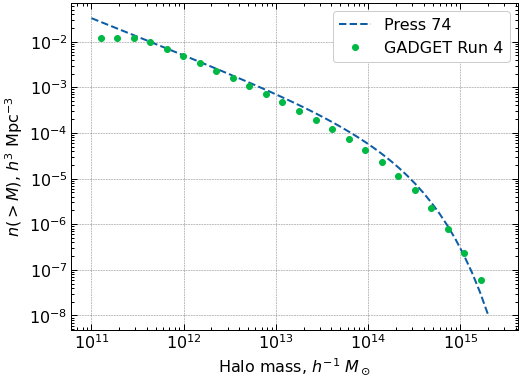

In [21]:
hc = snapshot.load("/home/aaronjo2/caps/astr510_sims/run4/fof_subhalo_tab_002.hdf5", load_subhalos=True)

hmf_angulo = halos.hmfunc.MassFuncAngulo12(cosmo)
hmf_press = halos.hmfunc.MassFuncPress74(cosmo)
hmf_tinker = halos.hmfunc.MassFuncTinker08(cosmo)

mass_ccl = np.logspace(11, 15.3, 50)
hmf_ps = hmf_press.get_mass_function(cosmo, mass_ccl, 1) * hc.h**3
hmf_ang = hmf_angulo.get_mass_function(cosmo, mass_ccl, 1) * hc.h**3
hmf_tink = hmf_tinker.get_mass_function(cosmo, mass_ccl, 1) * hc.h**3

mass_bins = np.logspace(11.1, 15.4, 25)
hmf, errors = hc.calc_fof_hmf(mass_bins)

plt.plot(mass_ccl, hmf_ps, '--', label="Press 74")
plt.plot(mass_bins, hmf, 'o', label="GADGET Run 4")
#plt.errorbar(mass_bins, hmf, yerr=errors, fmt='o', label="GADGET run 4")
plt.loglog()
plt.xlabel("Halo mass, $h^{-1}$ $M_\\odot$")
plt.ylabel("$n(>M)$, $h^3$ Mpc$^{-3}$")
plt.legend()
plt.show()

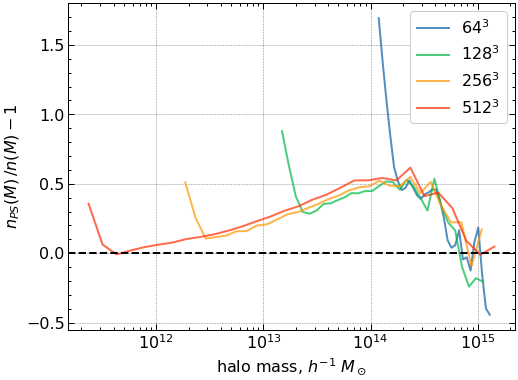

In [50]:
labels = ["$64^3$", "$128^3$", "$256^3$", "$512^3$"]
#plt.figure(dpi=300)
for i in range(1, 5):
    hc = snapshot.load(f"/home/aaronjo2/caps/astr510_sims/run{i}/fof_subhalo_tab_002.hdf5")
    mass_bins = np.logspace(np.log10(np.min(hc.masses)/1.5), np.log10(np.max(hc.masses))-0.1, 30)
    hmf, _ = hc.calc_fof_hmf(mass_bins)
    hmf_ps = hmf_press.get_mass_function(cosmo, mass_bins, 1) * hc.h**3
    error = hmf_ps / hmf - 1
    plt.plot(mass_bins, error, alpha=0.7, label=labels[i-1])
    

#plt.plot(mass_ccl, hmf_ps, 'k--', alpha=0.6)
#plt.title("FoF groups")
plt.xlabel("halo mass, $h^{-1}$ $M_\odot$")
plt.ylabel("$n_{PS}(M)\, / n(M) - 1$")
plt.axhline(0, ls='--', color='black')
plt.legend()
plt.xscale('log')
plt.show()

## Density profiles

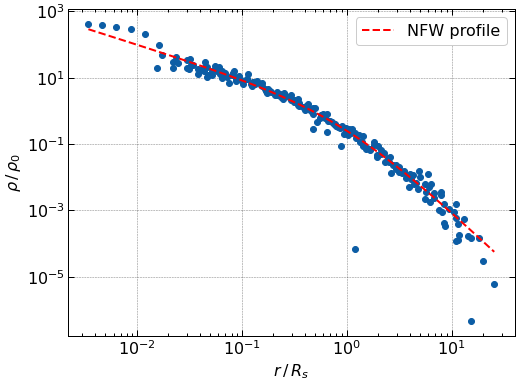

In [35]:
data = np.load("summary_data/run4/density_profiles_002.npz")

r = np.logspace(np.log10(np.min(data["r_scaled"])), np.log10(np.max(data["r_scaled"])), 50)
nfw_profile = 1/(r * (1+r)**2)

plt.plot(data["r_scaled"], data["density_scaled"], 'o')
plt.plot(r, nfw_profile, 'r--', label="NFW profile")
plt.loglog()
plt.xlabel("$r\,/\,R_s$")
plt.ylabel("$\\rho\,/\,\\rho_0$")
plt.legend()
#plt.ylim(top=1e3)
plt.show()

# Box size
runs 13 - 15

[27.379158 50.878098 42.887207]


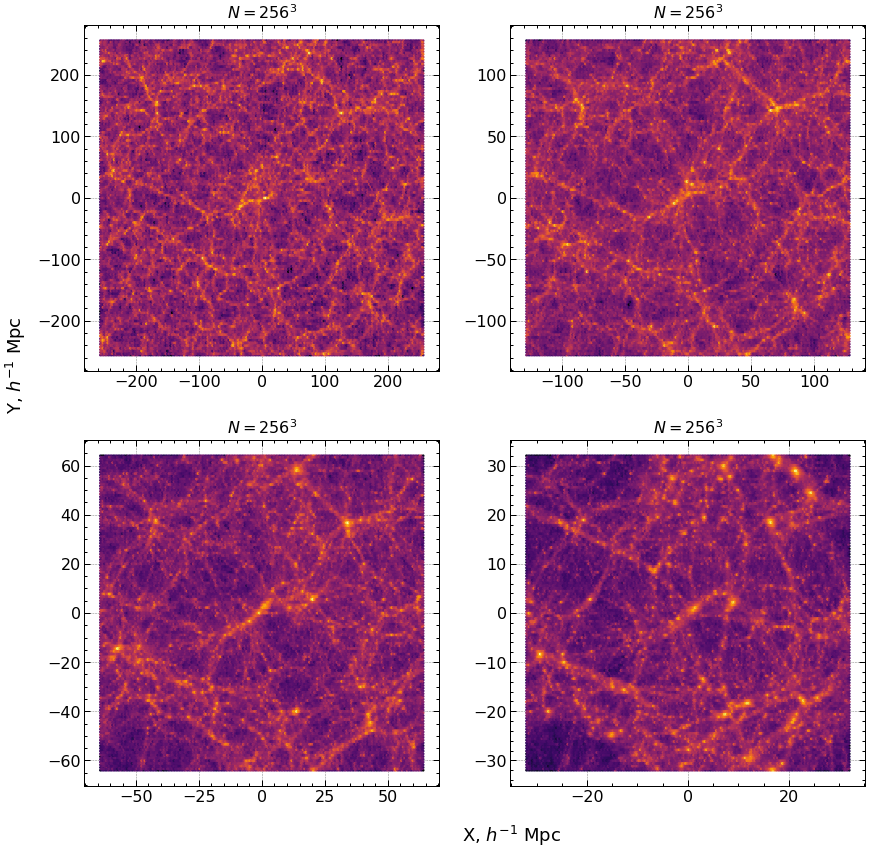

In [42]:
hc = snapshot.load("/home/aaronjo2/caps/astr510_sims/run15/fof_subhalo_tab_002.hdf5")
print(hc.pos[0])

center = np.array([27, 51, 43])
center = np.array([0, 0, 0])
gridsizes = [200, 200, 200, 200]

plt.figure(figsize=(14,14))
for i, snap in enumerate([13, 3, 14, 15]):
    plt.subplot(2,2,i+1)
    pd = snapshot.load(f"/home/aaronjo2/caps/astr510_sims/run{snap}/snapshot_002.hdf5", load_vels=False)
    pos = utils.center_box_pbc(pd.pos, center, pd.box_size)
    zslice = np.abs(pos[:,2]) < 20
    mask = np.nonzero(zslice)
    plt.hexbin(pos[mask,0], pos[mask,1], norm=LogNorm(), cmap="inferno", gridsize=gridsizes[i-1])
    plt.title(f"$N = {round(pd.n_parts**(1/3))}^3$")

plt.figtext(0.045, 0.5, "Y, $h^{-1}$ Mpc", rotation="vertical", fontsize=18)
plt.figtext(0.5, 0.07, "X, $h^{-1}$ Mpc", fontsize=18)
plt.show()

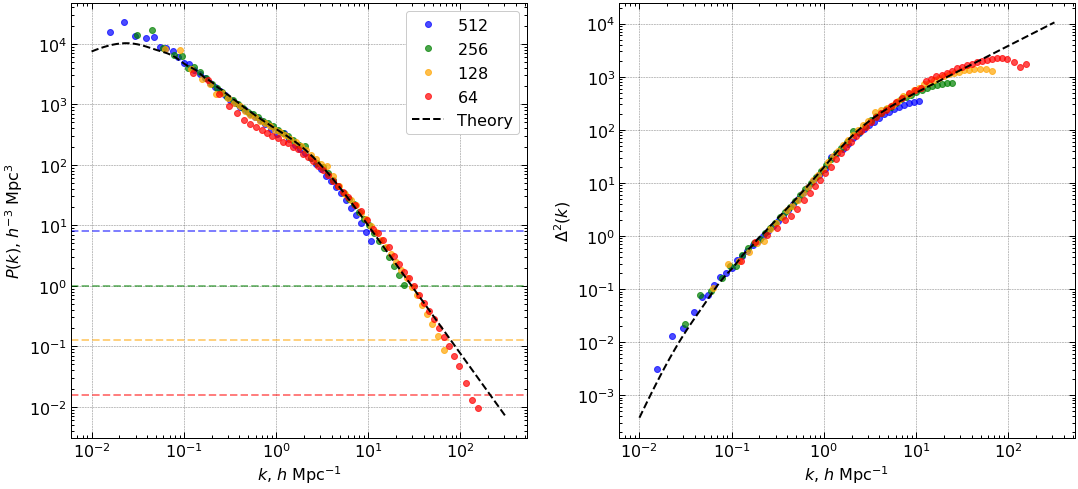

In [5]:
k_ccl = np.logspace(-2, 2.5, 100)
ps_ccl = cosmo.nonlin_power(k_ccl, 1)
delta_ccl = k_ccl**3 / (2*np.pi**2) * ps_ccl

shot_noise = [8, 1, 1/8, 1/64]
labels = ["$512$", "$256$", "$128$", "$64$"]
colors = ["blue", "green", "orange", "red"]
plt.figure(figsize=(18,8))

for i, snap in enumerate([13, 3, 14, 15]):
    data = np.load(f"summary_data/run{snap}/powerspec_002.npz")
    k = data["k"]
    delta = data["delta"]
    ps = 2*np.pi**2 * delta / k**3
    plt.subplot(1,2,1)
    plt.plot(k, ps, 'o', alpha=0.7, label=labels[i], color=colors[i])
    plt.axhline(shot_noise[i], ls='--', alpha=0.5, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(k, delta, 'o', alpha=0.7, label=labels[i], color=colors[i])

plt.subplot(1,2,1)
plt.plot(k_ccl, ps_ccl, 'k--', label="Theory")
plt.xlabel("$k$, $h$ Mpc$^{-1}$")
plt.ylabel("$P(k)$, $h^{-3}$ Mpc$^3$")
plt.loglog()
plt.legend()

plt.subplot(1,2,2)
plt.plot(k_ccl, delta_ccl, 'k--')
plt.loglog()
plt.xlabel("$k$, $h$ Mpc$^{-1}$")
plt.ylabel("$\\Delta^2(k)$")
plt.show()

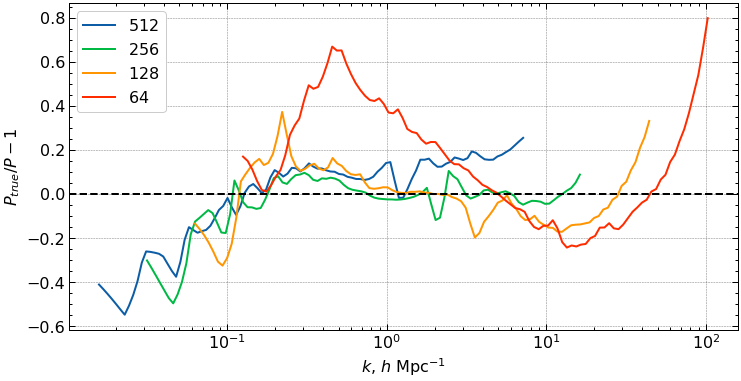

In [8]:
plt.figure(figsize=(12,6))
#plt.subplot(1,2,1)
errors = []
for i, snap in enumerate([13,3,14,15]):
    data = np.load(f"summary_data/run{snap}/powerspec_002.npz")
    k = data["k"]
    k_ccl = np.logspace(np.log10(np.min(k)), np.log10(np.max(k)/1.5), 100)
    delta = data["delta"]
    ps = 2*np.pi**2 * delta / k**3
    ps_interp = interp1d(k, ps)(k_ccl)
    ps_ccl = cosmo.nonlin_power(k_ccl, 1)

    transfer_func = ps_ccl / ps_interp
    error = np.linalg.norm(transfer_func - 1)
    errors.append(error)
    plt.plot(k_ccl, transfer_func - 1, label=labels[i])

plt.xscale('log')
plt.axhline(0, ls='--', color='black')
plt.xlabel("$k$, $h$ Mpc$^{-1}$")
plt.ylabel("$P_{true} / P - 1$")
plt.legend()

#plt.subplot(1,2,2)
#plt.plot([512, 256, 128, 64], errors, 'o--')
#plt.xscale('log')
#plt.xlabel("$N$")
#plt.ylabel("L2 eror")
plt.show()

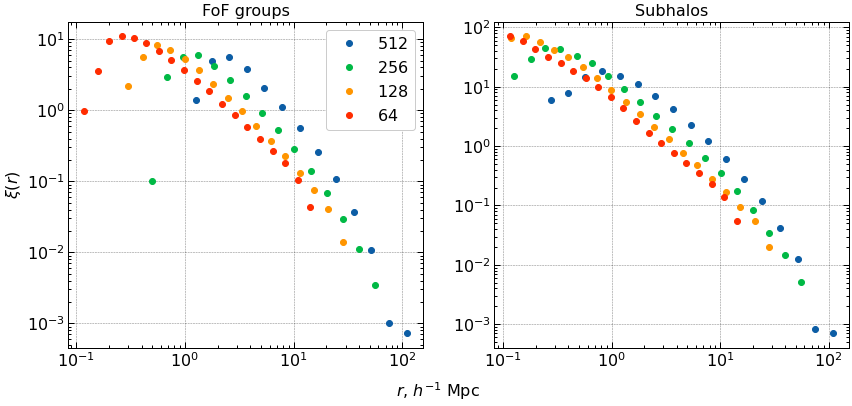

In [64]:
plt.figure(figsize=(14,6))
for i, snap in enumerate([13, 3, 14, 15]):
    data = np.load(f"summary_data/run{snap}/correlations_002.npz")
    corr_fof = data["results_fof"]
    corr_sh = data["results_sh"]
    plt.subplot(1,2,1)
    plt.plot(corr_fof["ravg"], corr_fof["xi"], 'o', label=labels[i])
    plt.subplot(1,2,2)
    plt.plot(corr_sh["ravg"], corr_sh["xi"], 'o')
    
plt.subplot(1,2,1)
plt.title("FoF groups")
plt.legend()
plt.loglog()
plt.figtext(0.45, 0.01, "$r$, $h^{-1}$ Mpc", fontsize=16)
plt.ylabel("$\\xi(r)$")
plt.subplot(1,2,2)
plt.title("Subhalos")
plt.loglog()
plt.show()

# Initial Conditions
Runs 1-3: 2LPT

Runs 5-7: ZA

0.058400552417169065
0.09628100087246444
0.0882251119776896


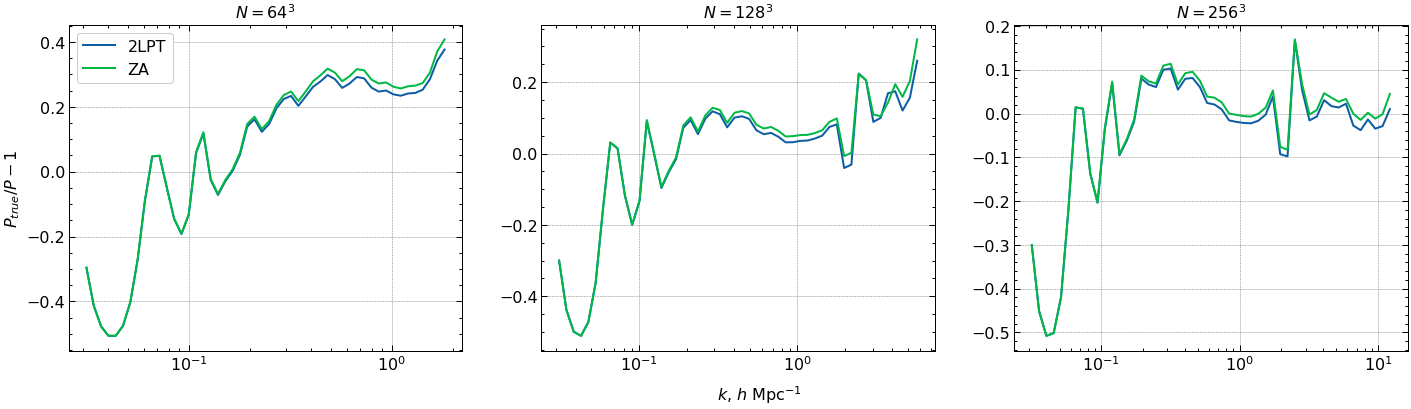

In [24]:
titles = ["$N = 64^3$", "$N = 128^3$", "$N = 256^3$"]

plt.figure(figsize=(24,6))
for i in range(1,4):
    data = np.load(f"summary_data/run{i}/powerspec_002.npz")
    k1 = data["k"]
    k_ccl = np.logspace(np.log10(np.min(k1)), np.log10(np.max(k1)/2), 50)
    ps_ccl = cosmo.nonlin_power(k_ccl, 1)
    delta1 = data["delta"]
    ps1 = 2*np.pi**2 * delta1 / k1**3
    ps1_interp = interp1d(k1, ps1, kind="cubic")(k_ccl)
    error1 = ps_ccl / ps1_interp - 1
    data = np.load(f"summary_data/run{i+4}/powerspec_002.npz")
    k2 = data["k"]
    delta2 = data["delta"]
    ps2 = 2*np.pi**2 * delta2 / k2**3
    ps2_interp = interp1d(k2, ps2, kind="cubic")(k_ccl)
    error2 = ps_ccl / ps2_interp - 1
    diff = np.linalg.norm(error1 - error2) / np.linalg.norm(error1)
    print(diff)
    plt.subplot(1,3,i)
    plt.plot(k_ccl, error1, label="2LPT")
    plt.plot(k_ccl, error2, label="ZA")
    if i == 1:
        plt.legend()
        plt.ylabel("$P_{true} / P - 1$")
    plt.xscale('log')
    plt.title(titles[i-1])
    
plt.figtext(0.5, 0.01, "$k$, $h$ Mpc$^{-1}$", fontsize=16)
plt.show()

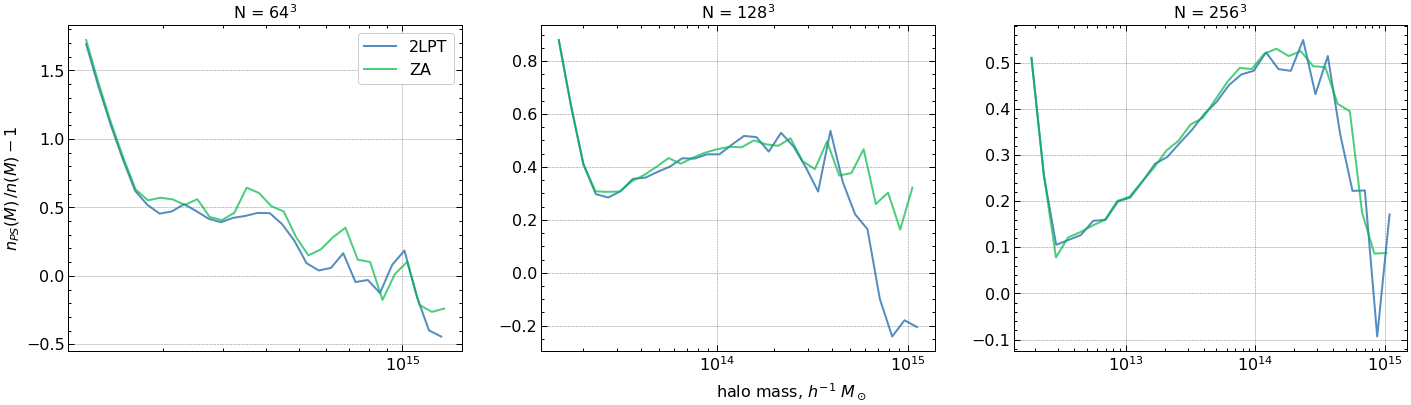

In [45]:
labels = ["$64^3$", "$128^3$", "$256^3$", "$512^3$"]
plt.figure(figsize=(24,6))
for i in range(1, 4):
    hc = snapshot.load(f"/home/aaronjo2/caps/astr510_sims/run{i}/fof_subhalo_tab_002.hdf5")
    mass_bins1 = np.logspace(np.log10(np.min(hc.masses)/1.5), np.log10(np.max(hc.masses))-0.1, 30)
    hmf1, _ = hc.calc_fof_hmf(mass_bins1)
    error1 = hmf_press.get_mass_function(cosmo, mass_bins1, 1) * hc.h**3 / hmf1 - 1
    hc = snapshot.load(f"/home/aaronjo2/caps/astr510_sims/run{i+4}/fof_subhalo_tab_002.hdf5")
    mass_bins2 = np.logspace(np.log10(np.min(hc.masses)/1.5), np.log10(np.max(hc.masses))-0.1, 30)
    hmf2, _ = hc.calc_fof_hmf(mass_bins2)
    error2 = hmf_press.get_mass_function(cosmo, mass_bins2, 1) * hc.h**3 / hmf2 - 1
    
    plt.subplot(1,3,i)
    plt.plot(mass_bins1, error1, alpha=0.7, label="2LPT")
    plt.plot(mass_bins2, error2, alpha=0.7, label="ZA")
    plt.xscale('log')
    plt.title("N = " + labels[i-1])
    if i == 1:
        plt.legend()
        plt.ylabel("$n_{PS}(M)\, / n(M) - 1$")
    

#plt.plot(mass_ccl, hmf_ps, 'k--', alpha=0.6)
#plt.title("FoF groups")
plt.figtext(0.5, 0.02, "halo mass, $h^{-1}$ $M_\odot$", fontsize=16)

plt.show()

# Softening length

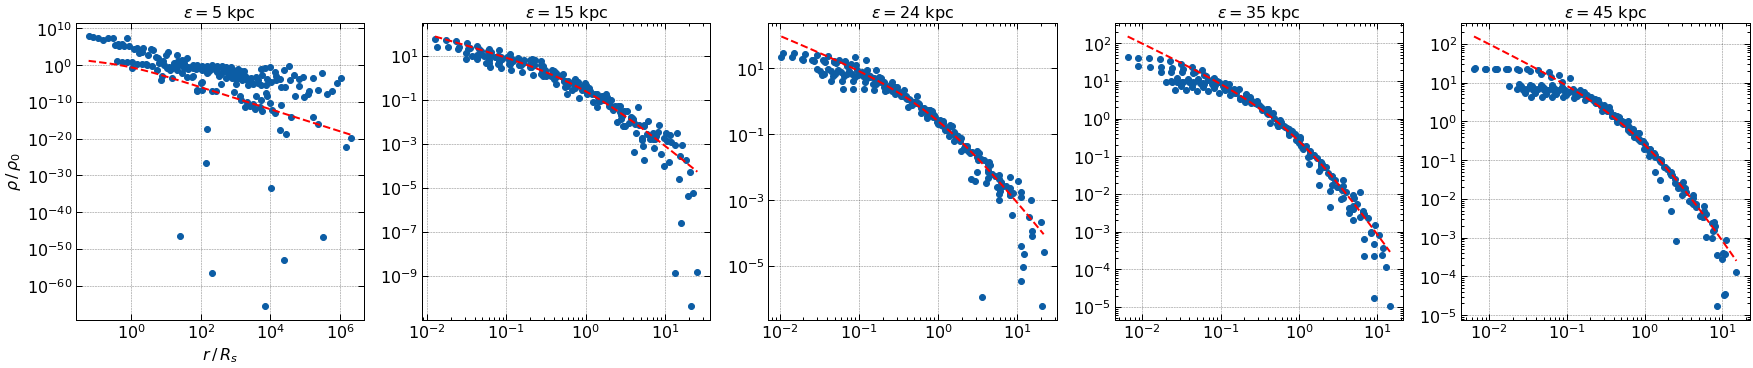

In [26]:
eps_vals = [5, 15, 24, 35, 45]

plt.figure(figsize=(30,12))

for i, snap in enumerate([8, 9, 3, 10, 11]):
    data = np.load(f"summary_data/run{snap}/density_profiles_002.npz")

    r = np.logspace(np.log10(np.min(data["r_scaled"])), np.log10(np.max(data["r_scaled"])), 50)
    nfw_profile = 1/(r * (1+r)**2)

    #plt.subplot(2, 5, i+1)
    #plt.plot(data["r"], data["density"], 'o')
    #plt.loglog()
    #plt.title(f"$\\epsilon = {eps_vals[i]}$ kpc")
    #if i == 0:
    #    plt.xlabel("r, Mpc")
    #    plt.ylabel("$\\rho$")
    
    plt.subplot(2,5,i+6)
    plt.plot(data["r_scaled"], data["density_scaled"], 'o')
    plt.plot(r, nfw_profile, 'r--', label="NFW profile")
    plt.title(f"$\\epsilon = {eps_vals[i]}$ kpc")
    plt.loglog()
    if i == 0:
        plt.xlabel("$r\,/\,R_s$")
        plt.ylabel("$\\rho\,/\,\\rho_0$")


plt.show()

-0.04026448413006335
-0.02476958960478672
-0.02554835688755687
0.012798376316679995
0.019768968544077944


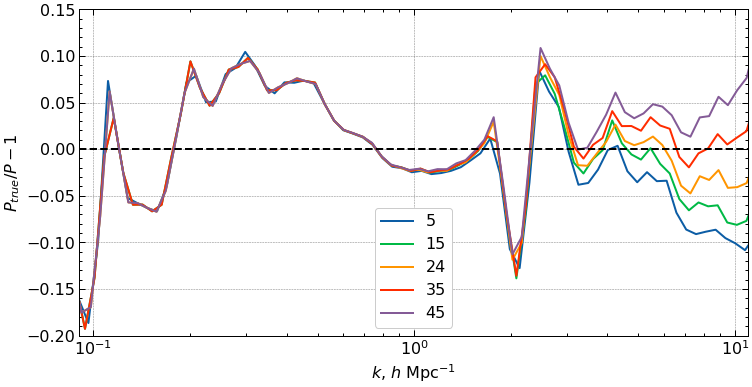

[1.4475472654857706,
 1.7087605197318667,
 1.538638029202877,
 2.1278000877906833,
 2.2690562009745556]

In [53]:
plt.figure(figsize=(12,6))
#plt.subplot(1,2,1)
labels = ["5", "15", "24", "35", "45"]
errors = []
for i, snap in enumerate([8,9,3,10,11]):
    data = np.load(f"summary_data/run{snap}/powerspec_002.npz")
    k = data["k"]
    k_ccl = np.logspace(np.log10(np.min(k)), np.log10(np.max(k)), 100)
    delta = data["delta"]
    ps = 2*np.pi**2 * delta / k**3
    ps_interp = interp1d(k, ps)(k_ccl)
    ps_ccl = cosmo.nonlin_power(k_ccl, 1)

    transfer_func = ps_ccl / ps_interp
    error = np.linalg.norm(transfer_func - 1)
    print(np.mean(transfer_func - 1))
    errors.append(error)
    plt.plot(k_ccl, transfer_func - 1, label=labels[i])

plt.xscale('log')
plt.xlim(0.9e-1, 1.1e1)
plt.ylim(-0.2, 0.15)
plt.axhline(0, ls='--', color='black')
plt.xlabel("$k$, $h$ Mpc$^{-1}$")
plt.ylabel("$P_{true} / P - 1$")
plt.legend()

#plt.subplot(1,2,2)
#plt.plot([512, 256, 128, 64], errors, 'o--')
#plt.xscale('log')
#plt.xlabel("$N$")
#plt.ylabel("L2 eror")
plt.show()
errors

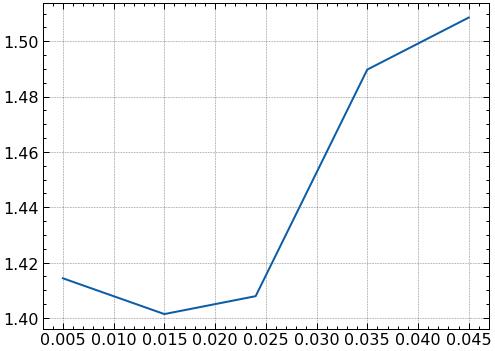

In [39]:
eps = [0.005, 0.015, 0.024, 0.035, 0.045]
plt.plot(eps, errors)